In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from propagation import laser
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
plt.style.use('notes')

path = '/media/robert/Data_Storage/Data/Experimental/Lithium_Oven_Optic_1/'
lam = 0.796
# All length units are in um

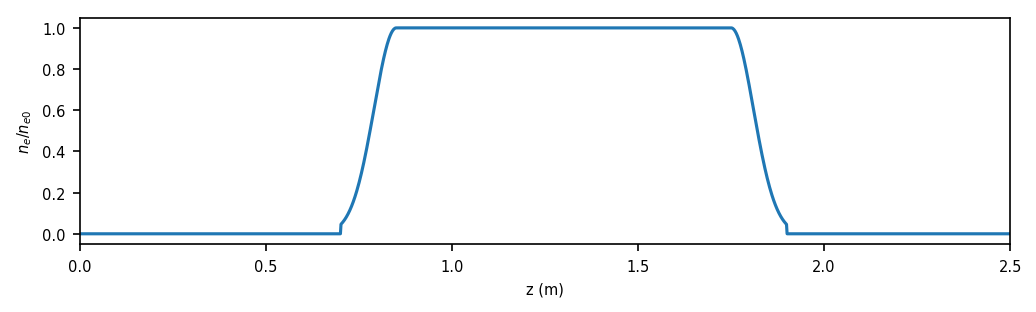

In [2]:
# Distance from picnic basket to oven start is 12in flange to flange
# Assume protected gold mirror for the final mirror
# Plasma density of 3.4e16 
# Plasma length is 60cm
# Ramp length we will estimate as 15cm each, beam should fully ionize this region
# There is 36in from the start of the flattop to the edge of the picnic basket
# Assume 0 is the dge of the picnic basket and the flattop is 1m downstream
length = 90e4
width = 200

# The optic positioning is very flexible

# Create the grid for the setup
Nz = 2**16
Z = 100e6 # Needs to be very large to provide resolution in the frequency domain
zi = -3e6
z, dz = np.linspace(zi, Z, Nz, retstep=True)
frac_l = np.zeros(Nz, dtype='double')

# On axis plasma density profile is given by
# Uniform accelerating plasma
z0 = 0.85e6 # start of the uniform plasma
sel_u = np.logical_and(z > z0, z < z0+length)
frac_l[sel_u] = 1.0

# Entrance ramp
l_ent = 15e4 # length of the entrance ramp
s_ent = 6e4
sel_ent = np.logical_and(z >= z0-l_ent, z <= z0)
ramp_ent = np.exp(-(z-z0)**2/(2*s_ent**2))
frac_l[sel_ent] = ramp_ent[sel_ent]

#Exit ramp
l_ext = 15e4 # length of the entrance ramp
s_ext = 6e4
sel_ext = np.logical_and(z >= z0+length, z <= z0+length+l_ext)
ramp_ext = np.exp(-(z-z0-length)**2/(2*s_ext**2))
frac_l[sel_ext] = ramp_ext[sel_ext]

xlim = [0, 2.5]
#xlim = [2.4, 4]
#xlim = [3.25, 4]
#xlim = [2, 2.5]
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, frac_l)
plt.xlabel(r'z (m)')
plt.ylabel(r'$n_e/n_{e0}$')
plt.xlim(xlim)
plt.show()

np.save(path+'plasma.npy', [z, frac_l])

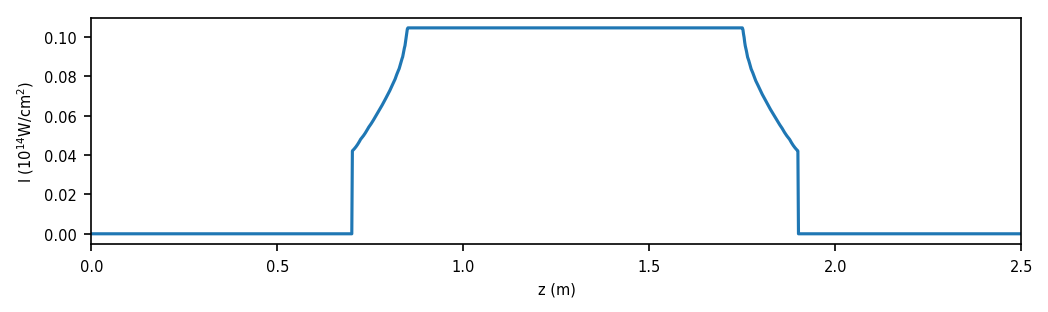

In [3]:
# Calculate the desired on axis intensity profile from the ionization fraction
# Assume a pulse with a Gaussian temporal shape
tau = 30 # RMS pulse length in fs
ion = {'atom' : ionization.Li,
       'tau' : tau,
       'type' : 'gaussian'}
I_l = ionization.intensity_from_density(ion, 0.999*frac_l)

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_l)
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()

Plasma starts at 0.25m and ends at 2.35m


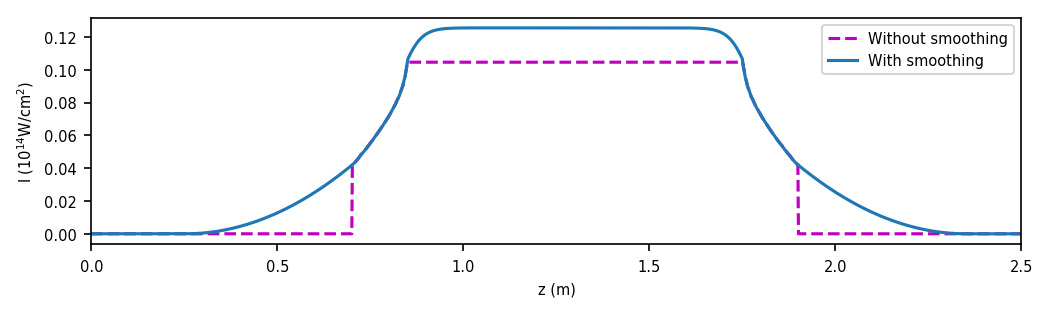

In [4]:
# The intensity profile needs to be smoothed to remove steps and hard corners

# Smooth the center section and increase the intensity
order = 8
Imax = np.amax(I_l)
z_u = z[sel_u]
zc = 0.5*(z_u[-1] + z_u[0])
w = (z_u[0] - zc)**(2*order)/0.6
I_la = np.copy(I_l)
I_new = 0.4*Imax*(np.exp(-(z_u - zc)**(2*order)/w)-0.5)
I_la[sel_u] += I_new

#Smooth the beginning of the entrance ramp with a parabola
I_ent = I_l[sel_ent]
gradI = (I_ent[1] - I_ent[0]) / dz
A = gradI**2 / (4*I_ent[0])
B = z[sel_ent][0] - 2*I_ent[0]/gradI
sel = np.logical_and(z >= B, z < z0-l_ent)
I_la[sel] = A*(z[sel]-B)**2
I_la[z < B] = 0.0
plasma_start = B

#Smooth the end of the exit ramp with a parabola
I_ext = I_l[sel_ext]
gradI = (I_ext[-1] - I_ext[-2]) / dz
A = gradI**2 / (4*I_ext[-1])
B = z[sel_ext][-1] - 2*I_ext[-1]/gradI
sel = np.logical_and(z <= B, z > z0+length+l_ext)
I_la[sel] = A*(z[sel]-B)**2
I_la[z > B] = 0.0
plasma_end = B

print('Plasma starts at %0.2fm and ends at %0.2fm' % (plasma_start/1e6, plasma_end/1e6))
plasma_size = [plasma_start, plasma_end]
np.save(path+'plasma_size.npy', plasma_size)

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_l, '--m')
plt.plot(z/1e6, I_la)
plt.legend(['Without smoothing', 'With smoothing'])
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()

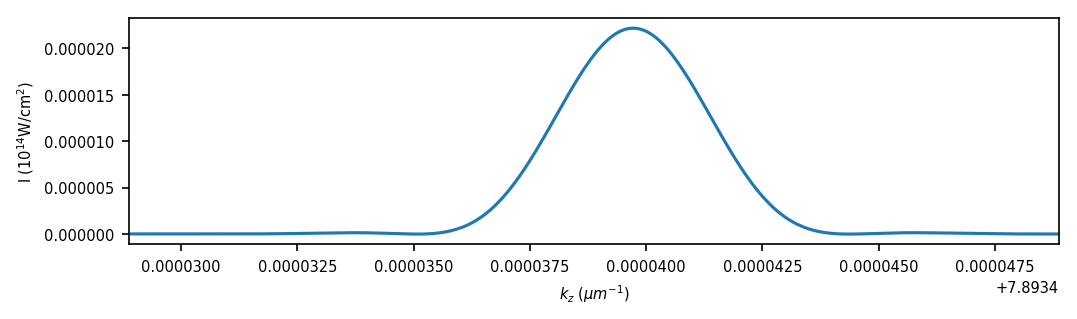

In [5]:
# Lets look at the spatial frequency componenets of the ramp
# The end of the plot is the maximum supported frequency
params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : width,
    'lam' : lam
}
r = np.linspace(0, params['R'], params['Nr'])
E = np.zeros(params['Nr'], dtype='complex128')
Ez = ionization.field_from_intensity(I_la)
k = 2*np.pi/lam
dz = z[1] - z[0]
# Shift frequencies
kr0 = 2.4048 / params['w']
kz0 = np.sqrt(k**2 - kr0**2)
kz = 2*np.pi * fftshift(fftfreq(Nz, dz)) + kz0
e = fftshift(fft(Ez)) / Nz

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(kz, ionization.intensity_from_field(e))
plt.xlabel(r'$k_z$ ($\mu m^{-1}$)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(k-2e-5, k)
plt.show()

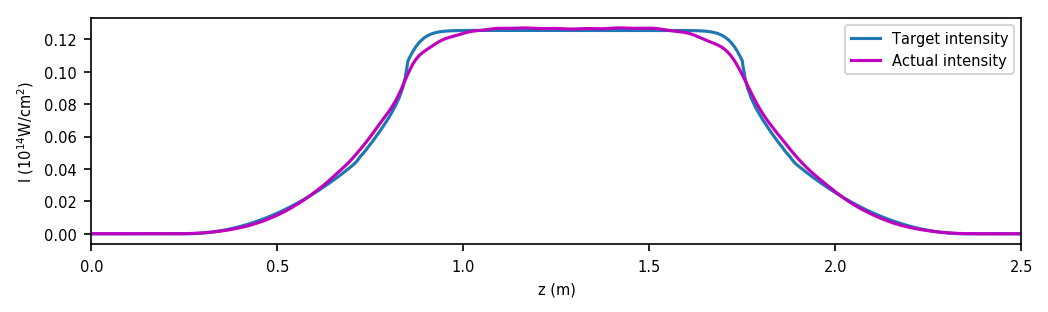

In [6]:
# Calculate the required intensity and phase profile after the beam shaping optics
r, E = bessel.bessel_expansion(params, z, I_la)
zFres = np.linspace(1e5, 8e6, 1000)
eFres = laser.fresnel_axis(E, r, zFres, lam)
IFres = ionization.intensity_from_field(eFres)

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_la)
plt.plot((zFres+zi)/1e6, IFres, 'm')
plt.legend(['Target intensity', 'Actual intensity'])
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()

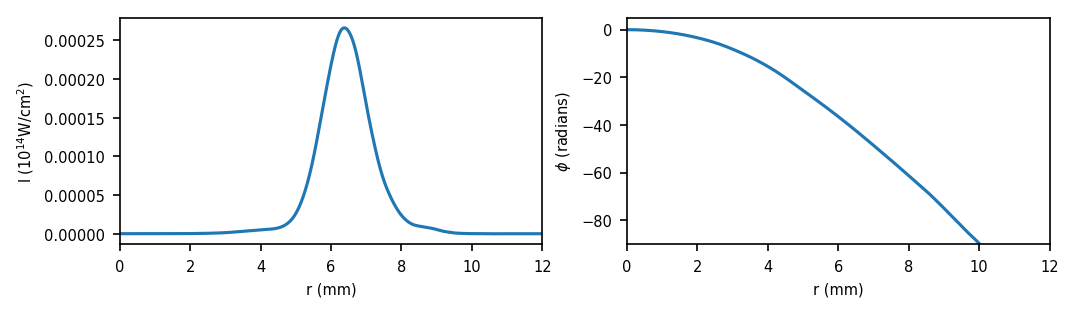

In [7]:
# Radial dependence of the phase and and intensity after the beam shaping optics
rlim = [0, 12]
plt.figure(figsize=(8, 2), dpi=150)
plt.subplot(121)
plt.plot(r/1e3, ionization.intensity_from_field(E))
plt.xlabel(r'r (mm)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(rlim)
plt.subplot(122)
plt.plot(r/1e3, np.unwrap(np.angle(E)))
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(rlim)
plt.ylim(-90, 5)
plt.show()
np.save(path+'r.npy', r)
np.save(path+'e.npy', E)

Maximum phase change in one pixel 0.62 rad


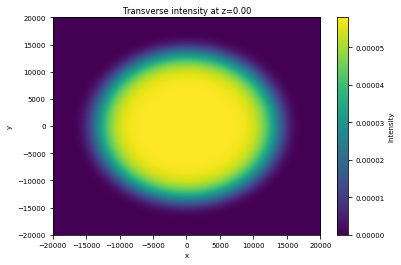

Peak power 0.07


In [8]:
# Design the tandem lenses to create the beam from the output of the laser
# First, we have to define what the incoming laser beam looks like
# Unifrom profile, place lens in the center of the flattop
E0 = 2.3
R_max = 10e3
r0 = np.linspace(0, R_max, len(r))
Ei = E0*np.ones(len(r))

# Call the first lens A and the second lens B first make sure the power is equal
Ii = ionization.intensity_from_field(Ei)
Io = ionization.intensity_from_field(E)
Pi = 2*np.pi*simps(r0*Ii*1e-4, r0*1e-4)*100
Po = 2*np.pi*simps(r*Io*1e-4, r*1e-4)*100
Ei *= np.sqrt(Po/Pi)
Ii = ionization.intensity_from_field(Ei)

# The first lens shapes the intensity on the second one
L = 45e4 # distance between the tandem optics
rA, phiA = ray.lens_design(Ii, r0, Io, r, L)
phiA *= 2*np.pi/lam

# Create the first lens
Nx = 2**12
X = 40e3
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensA',
              'lam' : lam,
              'load' : False}

lensA = optic.Phase(lensParams)
phi = lensA.reconstruct_from_cyl(rA, phiA, lensA.x, lensA.y)
lensA.initialize_phase(phi)

# The phase difference between neighboring cells must be less than pi
dphi = np.sort(abs(phi[1:, int(Nx/2+1)]-phi[:-1, int(Nx/2+1)]))[-3]
print('Maximum phase change in one pixel %0.2f rad' % dphi)

# Create the initial beam to pass through the lens
beamParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_A_to_B',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

# Super Gaussian for simulation
n = 8
w0 = 15e3
Ei = E0 * np.exp(-(r/w0)**n)*np.sqrt(Po/Pi)
beam0 = laserbeam.Laser(beamParams)
np.save(path+'initial_E.npy', Ei)
np.save(path+'initial_r.npy', r)
e = beam0.reconstruct_from_cyl(r, Ei, beam0.x, beam0.y)
beam0.initialize_field(e)
beam0.plot_current_intensity()
print('Peak power %0.2f' % (beam0.total_cyl_power(r, Ii)))

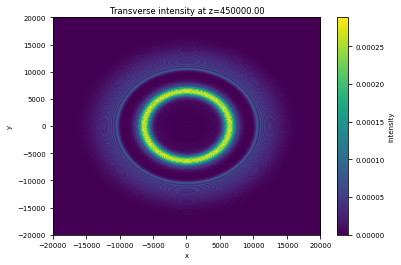

In [9]:
# Propagate the initial beam through the lens and to the second lens
# The actual phase at the second lens is needed to determine the phase delay of the lens
interactions.beam_phase(beam0, lensA)
beam0.propagate(L, 1.0)
beam0.plot_current_intensity()

In [10]:
# The second lens (B) removes the phase from the first lens and adds an axicon like phase
r0 = -beam0.x[:int(beam0.Nx/2+1)]
e0 = beam0.e[:int(beam0.Nx/2+1), int(beam0.Ny/2+1)]
phi0 = np.unwrap(np.angle(e0))
phi0 = phi0 - phi0[-1]
phiB = np.unwrap(np.angle(E)) - beam0.reconstruct_from_cyl(r0, phi0, r, np.zeros(1))[:, 0]

# Create the second lens, the domain is smaller for this one
Nx = 2**11
X = 20e3
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensB',
              'lam' : lam,
              'load' : False}

lensB = optic.Phase(lensParams)
phi = lensB.reconstruct_from_cyl(r, phiB, lensB.x, lensB.y)
lensB.initialize_phase(phi)
dphi = np.sort(abs(phi[1:, int(Nx/2+1)]-phi[:-1, int(Nx/2+1)]))[-3]
print('Maximum phase change in one pixel %0.2f rad' % dphi)

Maximum phase change in one pixel 2.52 rad


In [11]:
# Create a new beam after the phase shaping optics
beamParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam1_PostOptic',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam1 = laserbeam.Laser(beamParams)
e = beam1.reconstruct_from_cyl(r0, e0, beam1.x, beam1.y)
beam1.initialize_field(e)
interactions.beam_phase(beam1, lensB)

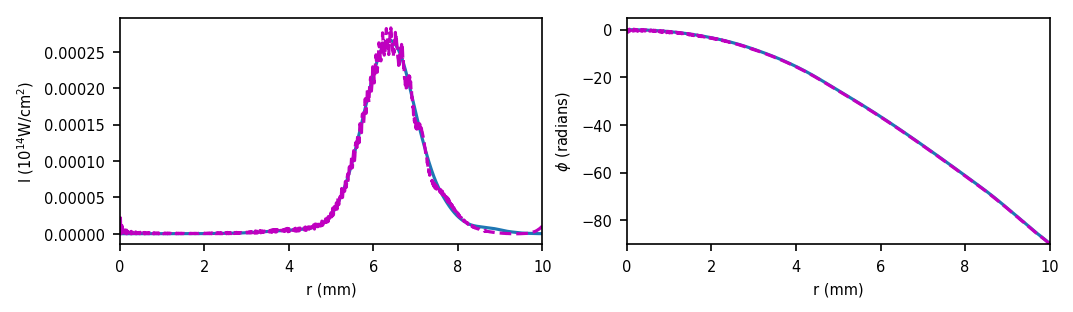

In [12]:
# Radial dependence of the phase and and intensity after the beam shaping optics
r1 = -beam1.x[:int(beam1.Nx/2+1)]
e1 = beam1.e[:int(beam1.Nx/2+1), int(beam1.Ny/2+1)]

rlim = [0, 10]
plt.figure(figsize=(8, 2), dpi=150)
plt.subplot(121)
plt.plot(r/1e3, ionization.intensity_from_field(E))
plt.plot(r1/1e3, ionization.intensity_from_field(e1), 'm--')
plt.xlabel(r'r (mm)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(rlim)
plt.subplot(122)
plt.plot(r/1e3, np.unwrap(np.angle(E)))
plt.plot(r1/1e3, np.unwrap(np.angle(e1))-np.unwrap(np.angle(e1))[-1], 'm--')
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(rlim)
plt.ylim(-90, 5)
plt.show()

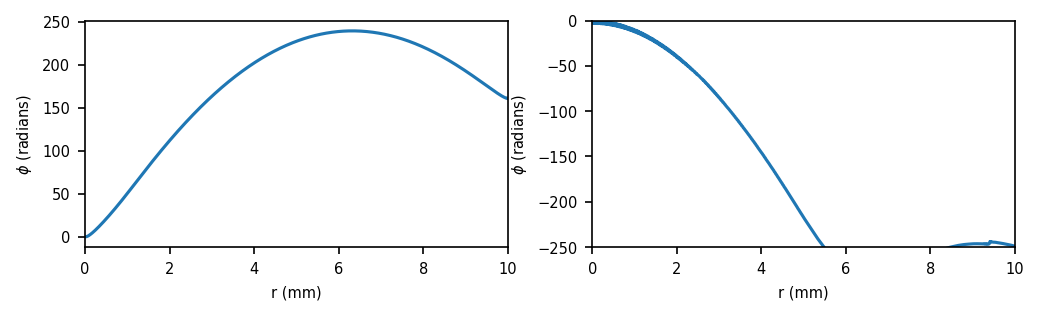

In [13]:
plt.figure(figsize=(8, 2), dpi=150)
plt.subplot(121)
plt.plot(rA/1e3, phiA)
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(0, np.amax(rA)/1e3)
plt.subplot(122)
plt.plot(r/1e3, phiB)
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(0, X/2e3)
plt.ylim(-250, 0)
plt.show()

In [14]:
sel = rA < 10e3
np.save(path+'lensA_Phase.npy', [rA[sel], phiA[sel]])
sel = r < 10e3
np.save(path+'lensB_Phase.npy', [r[sel], phiB[sel]])

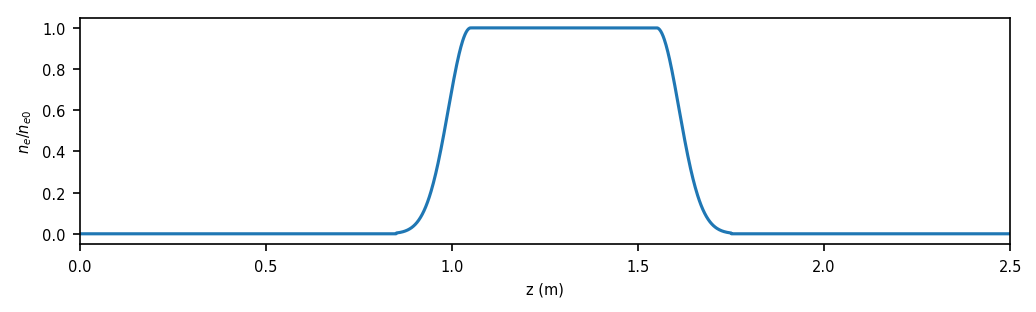

In [15]:
# Create the gas density the laser is going into
n = np.zeros(Nz, dtype='double')
length = 50e4
# Uniform accelerating plasma
z0 = 1.05e6 # start of the uniform plasma
sel_u = np.logical_and(z > z0, z < z0+length)
n[sel_u] = 1.0

# Entrance ramp
l_ent = 20e4 # length of the entrance ramp
s_ent = 6e4
sel_ent = np.logical_and(z >= z0-l_ent, z <= z0)
ramp_ent = np.exp(-(z-z0)**2/(2*s_ent**2))
n[sel_ent] = ramp_ent[sel_ent]

#Exit ramp
l_ext = 20e4 # length of the entrance ramp
s_ext = 6e4
sel_ext = np.logical_and(z >= z0+length, z <= z0+length+l_ext)
ramp_ext = np.exp(-(z-z0-length)**2/(2*s_ext**2))
n[sel_ext] = ramp_ext[sel_ext]

xlim = [0, 2.5]
#xlim = [2.4, 4]
#xlim = [3.25, 4]
#xlim = [2, 2.5]
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, n)
plt.xlabel(r'z (m)')
plt.ylabel(r'$n_e/n_{e0}$')
plt.xlim(xlim)
plt.show()
# Find the start for the refraction code
start = z0-l_ent
n = interp1d(z, n)

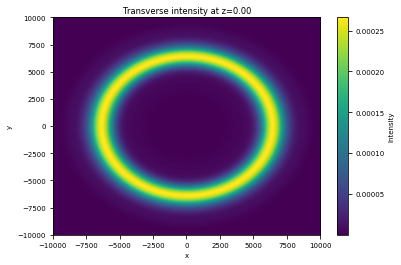

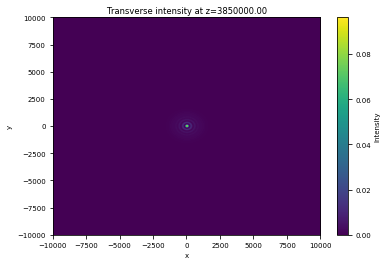

In [16]:
# Propagate the beam to the start of the plasma to minimize the size of the refraction simulation
Nx = 2**12
X = 20e3

pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : X,
    'Y' : X,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
    'name' : 'To_Start',
}
beam0 = laserbeam.Laser(pulseParams)
e = beam0.reconstruct_from_cyl(r, E, beam0.x, beam0.y)
beam0.initialize_field(e)
beam0.plot_current_intensity()
beam0.propagate(start-zi, 1.0)
beam0.plot_current_intensity()

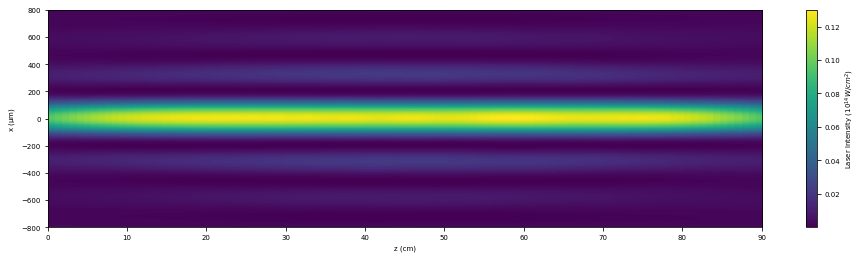

In [17]:
# Test to figure out how narrow of a domain we can use for the refraction simulation
Nx = 2**10
Nz = 100
X = 4e3
z1 = np.linspace(0, 90e4, Nz)
pulseParams['name'] = 'Test_Beam'
pulseParams['Nx'] = Nx
pulseParams['Ny'] = Nx
pulseParams['X'] = X
pulseParams['Y'] = X
beam1 = laserbeam.Laser(pulseParams)
e = beam1.rescale_field(beam0, beam1)
beam1.initialize_field(e)
beam1.propagate(z1, 1.0)

e1 = np.zeros((Nz, Nx), dtype='complex128')
for i in range(Nz):
    e1[i, :] = beam1.load_field(i+1)[0]
I = ionization.intensity_from_field(e1)

ext = [0, 90, -X/2, X/2]
plt.figure(figsize=(16, 4))
plt.imshow(np.flipud(np.transpose(I)), aspect='auto', extent=ext, cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.xlabel('z (cm)')
plt.ylabel(r'x ($\mathrm{\mu m}$)')
plt.ylim(-800, 800)
plt.show()

In [18]:
def plot_laser_plasma(I, ne, ext):
    plt.figure(figsize=(16, 4), dpi=150)
    plt.subplot(121)
    plt.imshow(np.flipud(np.transpose(I)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (cm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    plt.ylim(-500, 500)

    plt.subplot(122)
    plt.imshow(np.flipud(np.transpose(ne)), aspect='auto', extent=ext, cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'$n_e$ ($\mathrm{cm^{-3}}$)')
    plt.xlabel('$z$ (cm)')
    plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylim(-500, 500)
    plt.tight_layout()
    plt.show()

In [19]:
def refraction(m_e):
    Nx = 2**8
    Nz = 200
    Z = 90e4
    ne0 = 3.4e16/1e17
    pulseParams['name'] = 'Refracted_Beam'
    pulseParams['Nx'] = Nx
    pulseParams['Ny'] = Nx
    plasmaParams = {
        'Nx' : Nx,
        'Ny' : Nx,
        'Nz' : Nz,
        'X' : X,
        'Y' : X,
        'Z' : Z,
        'atom' : ionization.Li,
        'path' : path,
        'load' : False,
        'cyl' : True,
        'name' : 'Oven_Plasma',
        'n0' : ne0
    }

    pulse = laserpulse.Pulse(pulseParams)
    e = m_e*pulse.rescale_field(beam0, pulse)[None, :, :]*np.exp(-pulse.t[:, None, None]**2*np.pi/(2*tau**2))
    pulse.initialize_field(e)
    lithium = plasma.Plasma(plasmaParams)

    # Initialize gas density
    n_gas = np.zeros((Nx, Nx, Nz), dtype='double')
    ne = np.zeros((Nx, Nx, Nz), dtype='double')
    for i in range(Nz):
        n_gas[:, :, i] = n(lithium.z[i]+start)*ne0
    lithium.initialize_plasma(n_gas, ne)
    # Propagate the laser beam through the oven
    interactions.pulse_plasma(pulse, lithium)
    e = np.zeros((Nz, Nx), dtype='complex128')
    ne = np.zeros((Nz, Nx))
    for i in range(0, Nz-1):
        ne[i, :] = lithium.load_plasma_density(i)[0]
    for i in range(Nz):
        e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
    I = ionization.intensity_from_field(e)
    ne = ne*1e17
    return I, ne

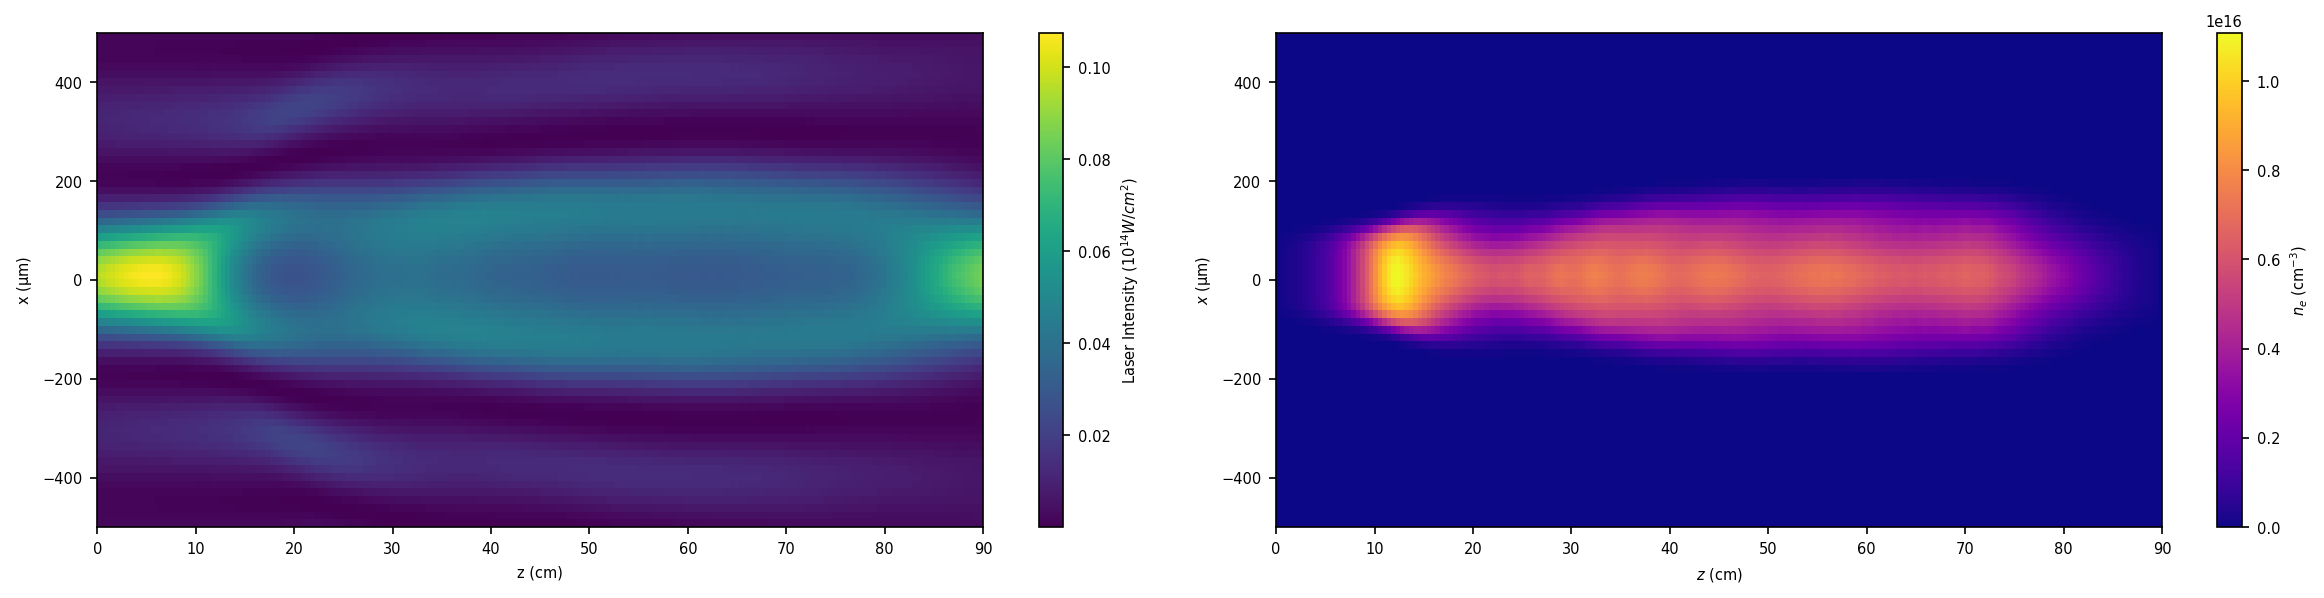

In [20]:
I, ne = refraction(1)
plot_laser_plasma(I, ne, ext)

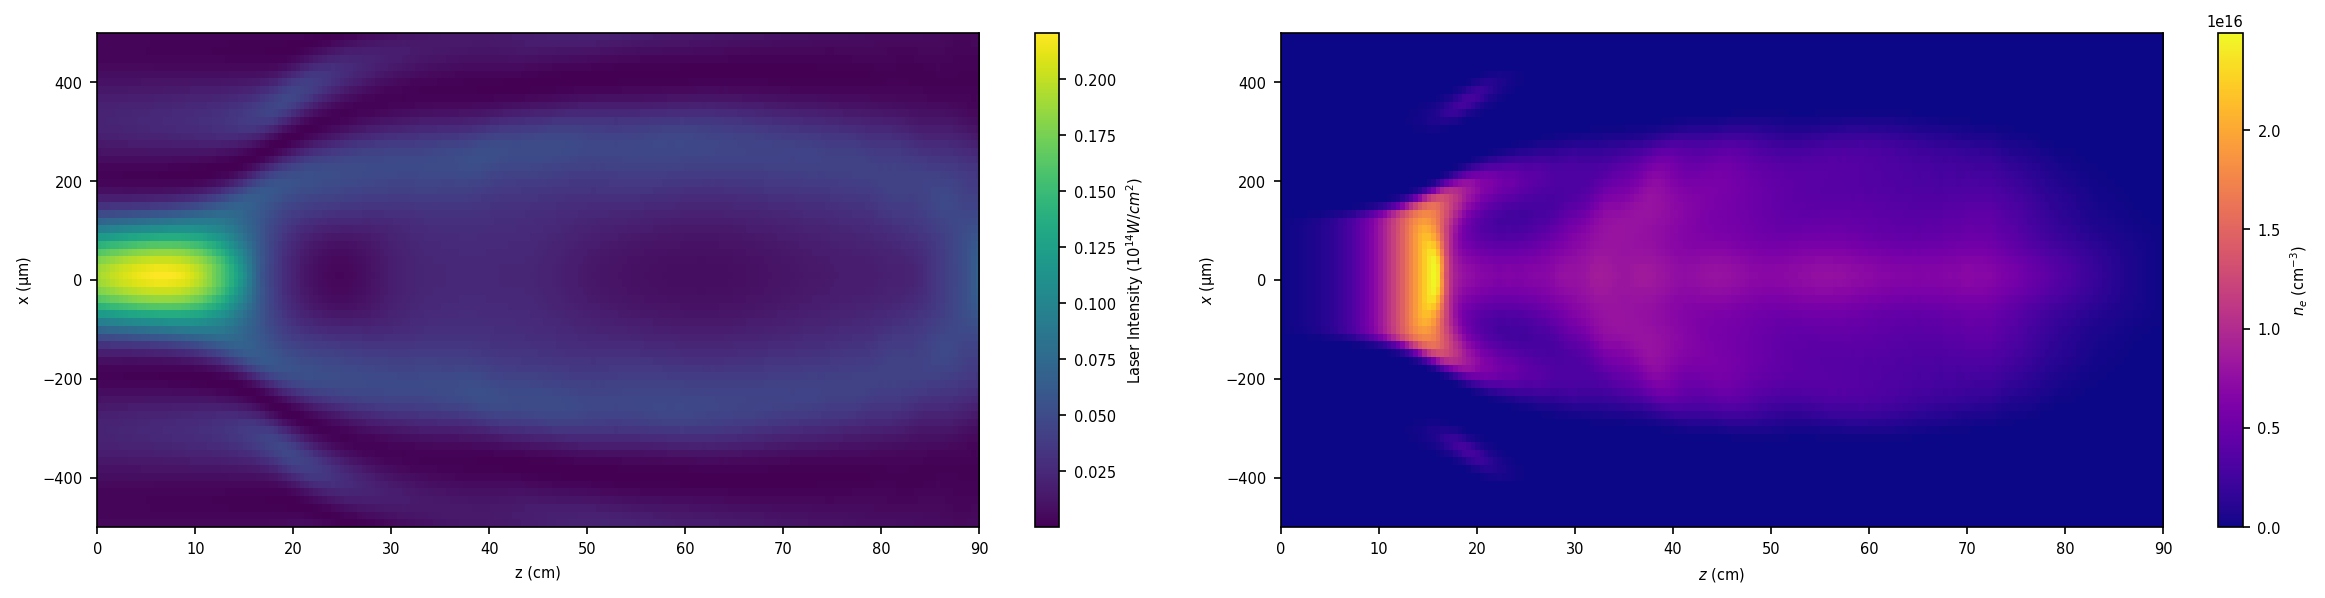

In [21]:
I, ne = refraction(1.41)
plot_laser_plasma(I, ne, ext)

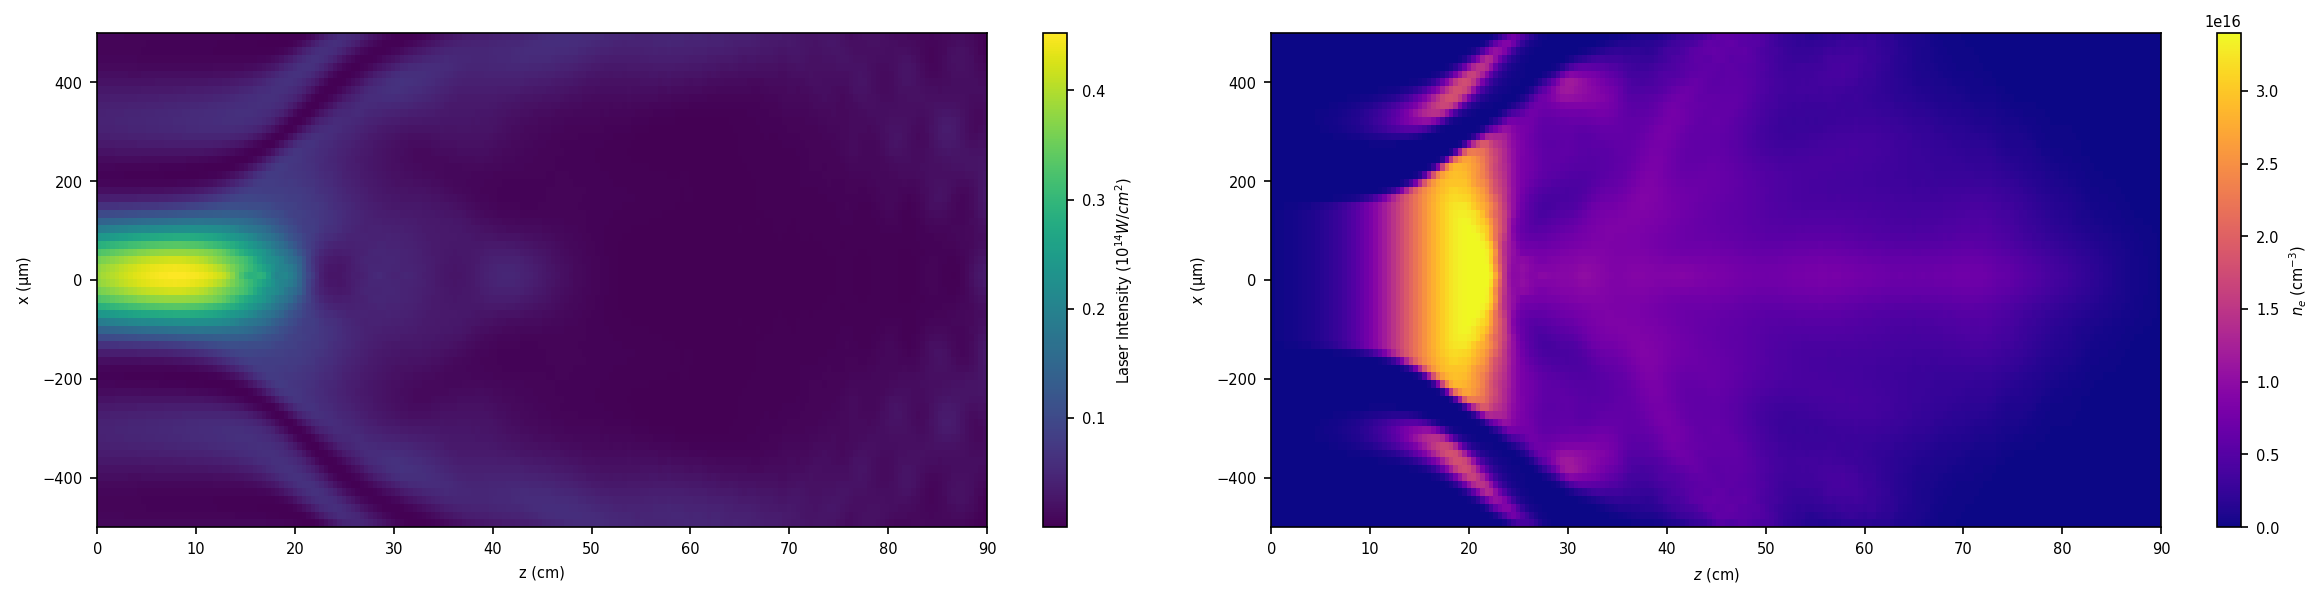

In [22]:
I, ne = refraction(2)
plot_laser_plasma(I, ne, ext)